<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/005_environmental_variables_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

In [2]:
!pip install -q -U rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 71.8 MB/s eta 0:00:00


In [3]:
import geemap
import geemap.colormaps as cm
import os, requests
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np

from google.colab import files
from google.colab import drive
from matplotlib.colors import LinearSegmentedColormap

## Trees

### Canopy Height (수관 높이)

Meta와 세계자원연구소(WRI: World Resources Institute)는 1미터 해상도의 전 세계 수관 높이 지도를 발표하여, 전 지구적으로 단일 나무를 감지할 수 있는 기능을 제공한다. 오픈 소스 산림 모니터링을 촉진하기 위해, 모든 수관 높이 데이터와 인공지능 모델은 무료로 공개된다.

Tolan, J., Yang, H.I., Nosarzewski, B., Couairon, G., Vo, H.V., Brandt, J., Spore, J., Majumdar, S., Haziza, D., Vamaraju, J., & Moutakanni, T. (2024). Creating highly detailed canopy height maps from RGB imagery with a self-supervised vision transformer and convolutional decoder, trained on aerial lidar data. Published in *Remote Sensing of Environment*, 300, p.113888.

https://meta-forest-monitoring-okw37.projects.earthengine.app/view/canopyheight
https://sustainability.atmeta.com/blog/2024/04/22/using-artificial-intelligence-to-map-the-earths-forests/
https://gee-community-catalog.org/projects/meta_trees/

In [9]:
# 대한민국 범위 좌표 지정(좌하단 : 우상단 좌표)
rectangle_coords = [
    [125.0765578311700068, 33.1124998462386984],
    [131.8727812628719960, 38.4000004985049017],
]

# 직사각형 생성
rectangle = ee.Geometry.Rectangle(rectangle_coords)

# 직사각형을 Feature로 변환
feature = ee.Feature(rectangle)

# FeatureCollection 생성
kor = ee.FeatureCollection([feature])

# NASA SRTM Digital Elevation 30m
elevation = ee.Image("USGS/SRTMGL1_003").select("elevation")

# 수역 마스크 생성
watermask = elevation.gt(0)

In [6]:
umd_height = ee.ImageCollection("users/potapovpeter/GEDI_V27").mosaic()
umd_height = umd_height.updateMask(watermask).clip(kor.geometry())

In [5]:
# Canopy Height 데이터셋 호출 및 모자이크 처리
canopy_height = ee.ImageCollection('projects/meta-forest-monitoring-okw37/assets/CanopyHeight').mosaic()

# canopyHeight >= 1인 지역만 선택
canopy_height = canopy_height.updateMask(canopy_height.gte(1))

# 수역 마스크 적용
canopy_height = canopy_height.updateMask(watermask).clip(kor.geometry())

# 레이어 추가 호출
eth_canopy_height = ee.Image('users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1')
umd_height = ee.ImageCollection("users/potapovpeter/GEDI_V27").mosaic()

# 시각화 파라미터
vis_params = {
    "min": 0,
    "max": 25,
    "palette": ['440154', '3b528b', '21908d', '5ec962', 'fde725'],
}

# 지도 생성 및 레이어 추가
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

# ETH Global Canopy Height Layer 추가 (10m급)
Map.addLayer(eth_canopy_height, vis_params, 'Canopy Height Lang 2022 98%', False)

# UMD Canopy Height Layer 추가 (30m급)
Map.addLayer(umd_height, vis_params, 'Canopy Height Potapov 2021 95%', False)

# Global Canopy Height Layer 추가 (1m급)
Map.addLayer(canopy_height, vis_params, 'Canopy Height [meters]')

Map.centerObject(kor.geometry(), 6)
Map

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# WDPA 데이터셋 불러오기
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

wdpa_id = 30711 # 해당 ID를 가진 WDPA 경계 선택
wolchulsan = wdpa.filter(ee.Filter.eq('WDPAID', wdpa_id))

# 월출산 수관 높이
wolchulsan_canopy_height = canopy_height.clip(wolchulsan.geometry())

# 지도 생성 및 레이어 추가
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

# Global Canopy Height Layer 추가 (1m급)
Map.addLayer(wolchulsan_canopy_height, vis_params, 'Canopy Height [meters]')

Map.centerObject(wolchulsan.geometry(), 12)
Map

Map(center=[34.747401616513265, 126.67696599512222], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=wolchulsan_canopy_height,
    description='WOLCHULSAN_CANOPY_HEIGHT',
    folder='kari-sdm',
    scale=1,  # 이미지의 해상도
    region=wolchulsan.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)  # 60초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: READY
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: RUNNING
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: RUNNING
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: RUNNING
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: RUNNING
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: RUNNING
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: RUNNING
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: RUNNING
Polling for task (id: BG7CR2DQI5EE6WJYSQKDEU6Q). Status: COMPLETED
Task completed. Final status:
{'state': 'COMPLETED', 'description': 'WOLCHULSAN_CANOPY_HEIGHT', 'priority': 100, 'creation_timestamp_ms': 1723715739294, 'update_timestamp_ms': 1723716181707, 'start_timestamp_ms': 1723715745081, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1tgbSyRRPGeqiA4KO-qxQWNuLdrVcNj_z'], 'attempt': 1, 'batch_eecu

In [7]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=umd_height,
    description='CHT',
    folder='kari-sdm',
    scale=30,  # 이미지의 해상도
    region=kor.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)  # 60초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: READY
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: RUNNING
Polling for task (id: XVJNEJO2XUPKQP23EC6QXFSL). Status: COMPLETED
Task completed. Final status:
{'state': 'COMPLETED', 'description': 'CHT', 'priority': 100, 'creation_timestamp_ms': 1723787604981, 'update_timestamp_ms': 1723788206363, 'start_timestamp_ms': 1723787609898, 'task_type': 'EXPORT_IMAGE', 'destinat

In [10]:
# Google Drive를 마운트
drive.mount('/content/drive')

Mounted at /content/drive


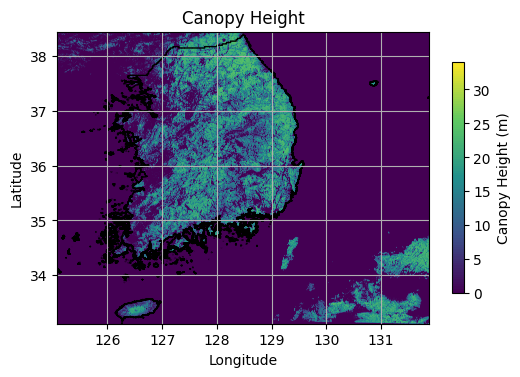

In [11]:
# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"
img_path = os.path.join(folder_path, "CHT.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 사용자 정의 컬러맵 생성
colors = [
    [0.2667, 0.0039, 0.3294],
    [0.2314, 0.3216, 0.5451],
    [0.1294, 0.5647, 0.5529],
    [0.3686, 0.7882, 0.3843],
    [0.9922, 0.9059, 0.1451]
]
cmap_name = 'custom_cmap'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap=cmap,
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Canopy Height (m)')

# 제목, 축 레이블, 그리드 설정
plt.title("Canopy Height")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()

In [ ]:
# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
tcc = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
tcc = (
    tcc.filterDate("2000-01-01", "2015-12-31")
    .select(["tree_canopy_cover"], ["TCC"])
    .median()
)
tcc = tcc.updateMask(watermask).clip(kor.geometry())

# TCC layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["TCC"],
    "min": 0,
    "max": 100,
    "palette": ["ffffff", "afce56", "5f9c00", "0e6a00", "003800"],
}
Map.addLayer(tcc, vis_params, "TCC")
Map.add_colorbar(
    vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC"
)
Map.centerObject(kor.geometry(), 6)
Map

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=tcc,
    description='TCC',
    folder='kari-sdm',
    scale=30,  # 이미지의 해상도
    region=kor.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)  # 60초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: READY
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Status: RUNNING
Polling for task (id: 5K3Q6MSLBMYD2JQ7R7WEL7ZG). Sta

In [ ]:
from rasterio.merge import merge
from rasterio.shutil import copy

# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"
file1 = os.path.join(folder_path, "TCC-0000000000-0000023296.tif")
file2 = os.path.join(folder_path, "TCC-0000000000-0000000000.tif")
output_file = os.path.join(folder_path, "TCC.tif")

# 두 개의 파일을 읽어들임
src_files_to_mosaic = []
for fp in [file1, file2]:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

# 파일을 합침
mosaic, out_trans = merge(src_files_to_mosaic)

# 메타데이터 업데이트
out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",  # 임시 파일로 먼저 저장하기 위한 드라이버 설정
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "compress": "lzw"  # 압축 옵션 설정
})

# 임시 파일로 GeoTIFF 저장
temp_output_file = os.path.join(folder_path, "temp_TCC.tif")
with rasterio.open(temp_output_file, "w", **out_meta) as dest:
    dest.write(mosaic)

# COG 옵션 설정
cog_options = {
    'driver': 'COG',
    'blocksize': 256,
    'resampling': 'nearest'  # 문자열로 전달되는 리샘플링 방법
}

# COG로 변환하여 최종 파일에 저장
copy(temp_output_file, output_file, **cog_options)

# 임시 파일 삭제
os.remove(temp_output_file)

# 파일 닫기
for src in src_files_to_mosaic:
    src.close()

print(f"합쳐진 파일이 COG 형식으로 '{output_file}'에 저장되었습니다.")

합쳐진 파일이 COG 형식으로 '/content/drive/My Drive/kari-sdm/TCC.tif'에 저장되었습니다.


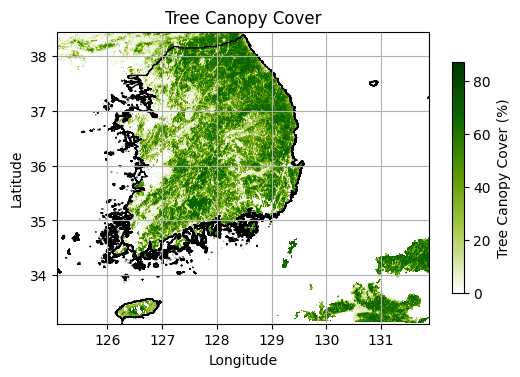

In [12]:
# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"
img_path = os.path.join(folder_path, "TCC.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 사용자 정의 컬러맵 생성
colors = ["#ffffff", "#afce56", "#5f9c00", "#0e6a00", "#003800"]
cmap_name = 'custom_cmap'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap=cmap,
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Tree Canopy Cover (%)')

# 제목, 축 레이블, 그리드 설정
plt.title("Tree Canopy Cover")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()